# Data Science for Networks

Notebook for the final project of the course.

In [14]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]
import time

## Stock pre-processing

In [15]:
def _date_parser(x):
    return pd.to_datetime(x, yearfirst=True, format='%Y-%m-%d')

data_dir = 'historical-prices'
files = os.listdir(data_dir)
files.sort()
len(files)

502

Parse stock sector information.

In [16]:
info = pd.read_csv("S&P500_wikipedia_info.csv", sep=';', header=0, index_col=0)
info = info[['Security', 'GICS_Sector']].dropna().sort_values(by=["GICS_Sector", "Security"])
info

,Security,GICS_Sector
Symbol,,
T,AT&T Inc.,Communication Services
ATVI,Activision Blizzard,Communication Services
GOOGL,Alphabet Inc Class A,Communication Services
GOOG,Alphabet Inc Class C,Communication Services
CBS,CBS Corp.,Communication Services
CTL,CenturyLink Inc,Communication Services
CHTR,Charter Communications,Communication Services
CMCSA,Comcast Corp.,Communication Services
DISCA,Discovery Inc. Class A,Communication Services


In [17]:
sec_count = info.groupby(["GICS_Sector"]).agg('count')
cum_sec_count = sec_count.cumsum()
cum_sec_count

,Security
GICS_Sector,
Communication Services,26
Consumer Discretionary,91
Consumer Staples,124
Energy,154
Financials,221
Health Care,282
Industrials,351
Information Technology,419
Materials,443


Retain only stocks whose series are complete in 2017.

In [18]:
desired_size = 251 # 503 for 2016+2017
stocks_dict = {}
for file in files:
    df = pd.read_csv(os.path.join(data_dir, file), header=0, index_col=0, parse_dates=True, 
                     date_parser=_date_parser)
    
    s = df.loc['2017':'2017', 'Close']
    
    if s.size == desired_size:
        s.name = file.split('_')[0]
        stocks_dict[s.name] = s

# create a list ordered by sectors and alphab. names
# all stocks not having a sector will be discarded
stock_series = []
for symbol in info.index:
    try:
        stock_series += [stocks_dict[symbol]]
    except KeyError:
        pass

print(len(stocks_dict.keys()), len(stock_series))

501 497


Find relative difference with respect to the previous day.

In [19]:
diffs = [s.diff() for s in stock_series]
pdiffs = [s.diff() / s.shift(1) for s in stock_series]
pdiffs = [s[1:] for s in pdiffs]
pdiffs = pdiffs[:-1] # discard first day

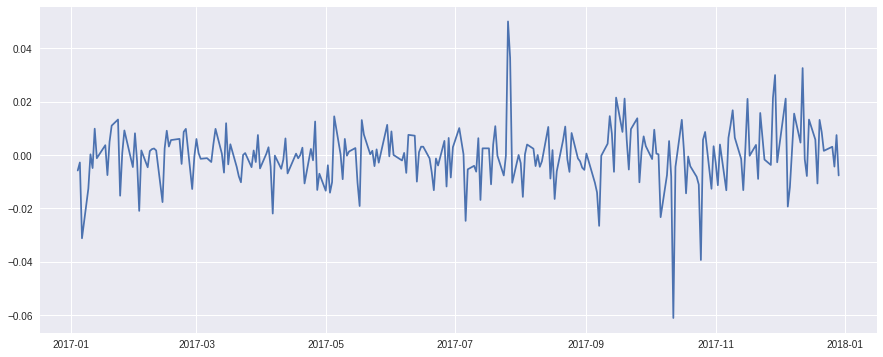

In [20]:
plt.plot(pdiffs[0].index, pdiffs[0])

## Define tensor and decompose

In [21]:
import numpy as np
import networkx as nx

In [22]:
# tensor shape
r_len = c_len = len(pdiffs)
t_len = pdiffs[0].size
r_len, c_len, t_len

(496, 496, 250)

In [23]:
X = np.zeros(shape=(r_len, c_len, t_len))

# growth threshold
tr = 0.02

start_time = time.time()
for t in range(t_len):
    print('\rt: {}/{}'.format(t+1, t_len), end='')
    for i, item_i in enumerate(pdiffs):
        
        # use symmetry
        for j in range(i+1):
            if i == j:
                continue
            
            item_j = pdiffs[j]
            if item_i.iloc[t] > tr and item_j.iloc[t] > tr:
                X[i][j][t] = 1
                X[j][i][t] = 1
print()
print('elapsed {} secs'.format(int(time.time() - start_time)))      

t: 250/250
elapsed 151 secs


Let's have a graph representation for **slices with time dimension fixed**

In [24]:
# base graph with one node per stock
G = nx.Graph()
for i, stock in enumerate(pdiffs):
    G.add_node(i, name=stock.name)

# build a list of graph, one per temporal slice
temporal_slices = []
for t in range(t_len):
    curr = nx.Graph()
    curr.add_nodes_from(G)
    temporal_slices += [curr]

# add edges to each slice
for t in range(t_len):
    for r in range(r_len):
        for c in range(r+1):
            if X[r][c][t] == 1:
                temporal_slices[t].add_edge(r,c)

### Analyze adjacency matrix

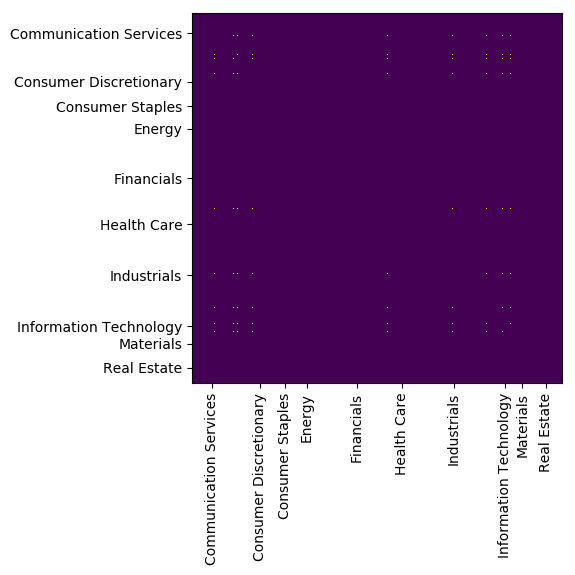

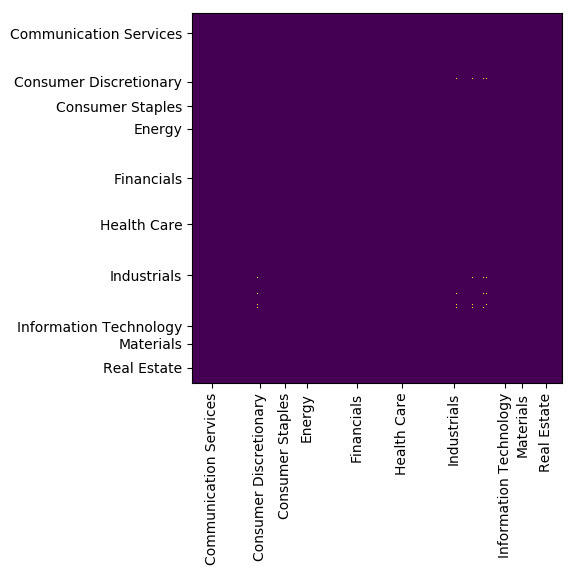

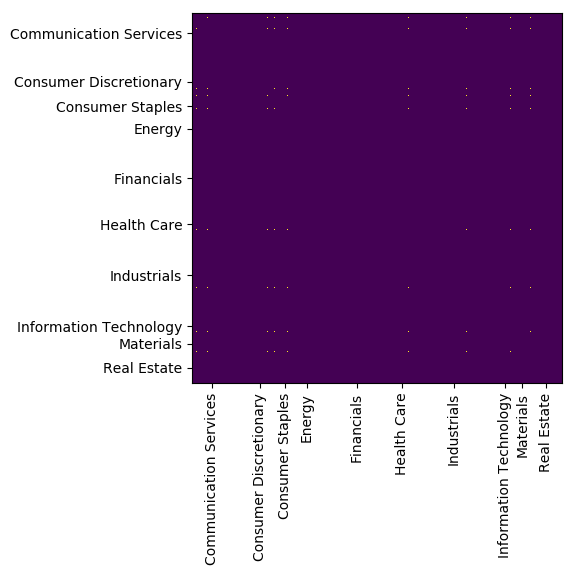

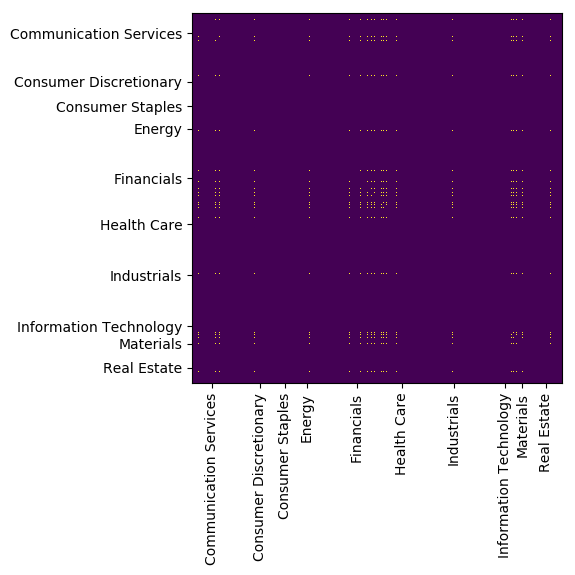

<Figure size 640x480 with 0 Axes>

In [25]:
from networkx.algorithms.components import number_connected_components, connected_components

plt.style.use('default')

for perc in [0.20, 0.40, 0.60, 0.80]:
    plt.yticks(cum_sec_count['Security'].values, cum_sec_count.index)
    plt.xticks(cum_sec_count['Security'].values, cum_sec_count.index, rotation='vertical')
    day = int(perc * t_len)
    g = temporal_slices[day]
    A = nx.adjacency_matrix(g).toarray()
    plt.imshow(A)
    plt.savefig('adj_{}.png'.format(day), bbox_inches='tight')
    plt.figure()
    
# print(g.order(), number_connected_components(g))
# list(connected_components(g))

### Analyze connected components versus time

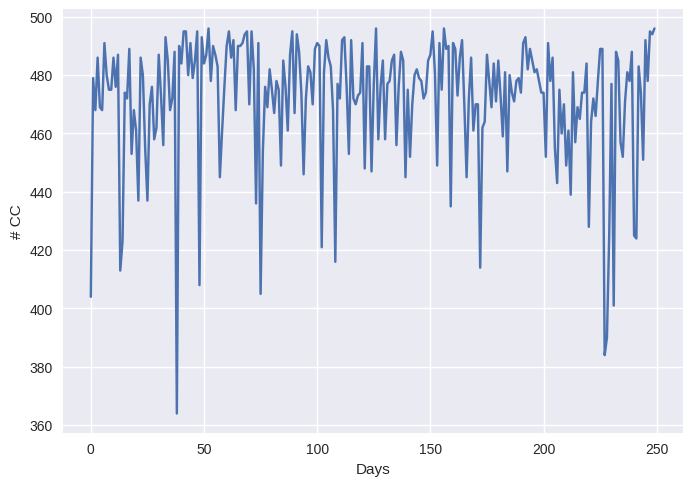

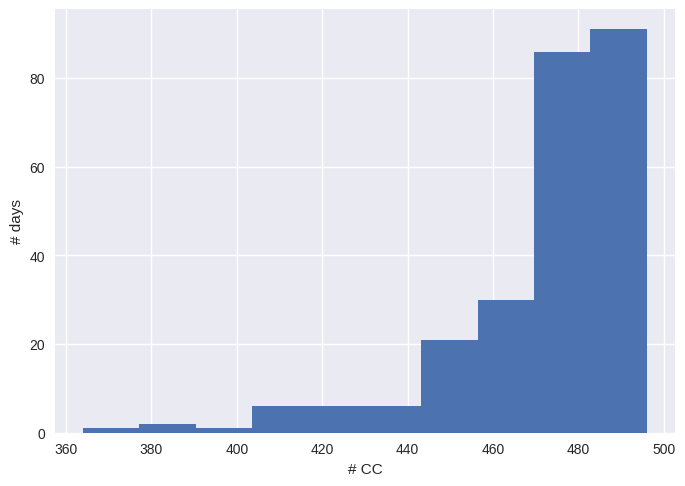

In [26]:
cc_by_time = np.zeros(t_len)
plt.style.use('seaborn')
for t in range(t_len):
    g = temporal_slices[t]
    cc_by_time[t] = number_connected_components(g)

plt.ylabel("# CC")
plt.xlabel("Days")
plt.plot(cc_by_time)
plt.savefig("cc_by_time.png")

plt.figure()
plt.ylabel("# days")
plt.xlabel("# CC")
plt.hist(cc_by_time)
plt.savefig("cc_distribution.png")

Try removing isolated connected components to have a representation of the single fully connected component.

In [38]:
isolated = list(nx.isolates(g))
g.remove_nodes_from(isolated)

/home/giuseppe/miniconda3/envs/dsnet/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


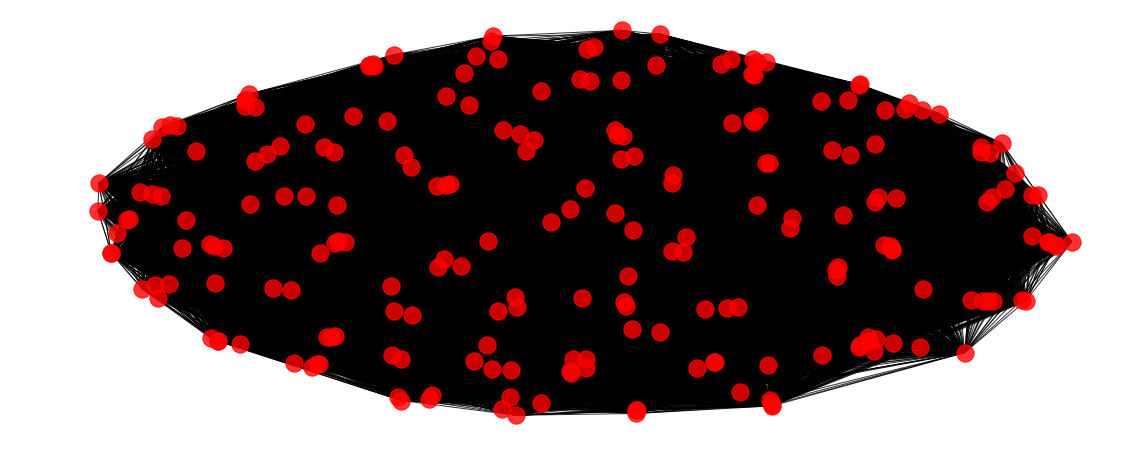

In [40]:
nx.draw(g, with_labels=False, alpha=0.8)

## Analyze latent factors

In [27]:
import tensorly as tl
from tensorly.decomposition import parafac, non_negative_parafac

TX = tl.tensor(X)

Plot error versus number of factors.

Find second derivative with Euler explicit approximation

In [ ]:
R = 52
S1, S2, T = parafac(TX, R)
# S1nn, S2nn, Tnn = non_negative_parafac(TX, R)

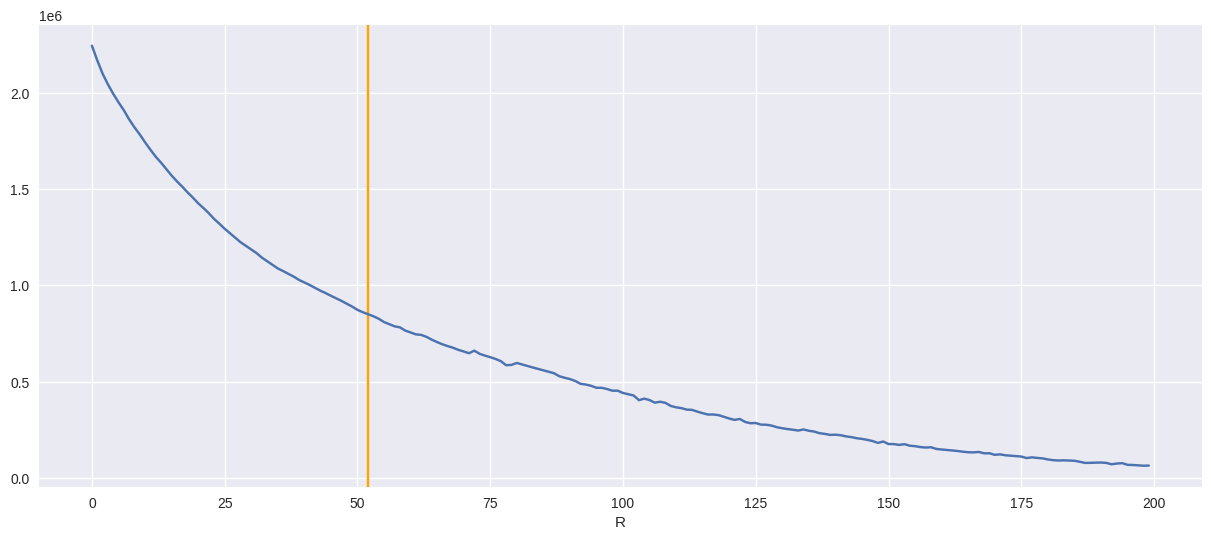

In [256]:
errors = np.load("R_errors.npy")
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]
plt.axvline(x=R, color='orange')
plt.xlabel("R")
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,1))
plt.plot(errors)
plt.savefig('errors_trend_line.png')

Code executed in advance. Results have been saved in a numpy array and 52 was chosen as R. 

### Factors charts

Even though 52 charts were computed, here only the first 10 are reported. Displaying all of them makes the notebook impossible to renderd by online platforms. The other factors are in the main root of the repository.

In [ ]:
top_k = int(0.05 * r_len)

for factor in range(10): # R):
    fig = plt.figure(figsize=(10,9))
    fig.suptitle('Factor {}'.format(factor))
    grid = plt.GridSpec(2, 2, hspace=0.7)
    
    tl = fig.add_subplot(grid[0,0])
    plt.xticks(rotation=90)
      
    sectors_dict = dict.fromkeys(cum_sec_count.index.values, 0.)
    for idx in S1[:, factor].argsort()[:-top_k:-1]:
        sect = info.iloc[idx]['GICS_Sector']
        sectors_dict[sect] += S1[idx, factor]
        # print(idx, info.iloc[idx]['Security'], info.iloc[idx]['GICS_Sector'], S1[idx, factor])
    tl.bar(sectors_dict.keys(), sectors_dict.values())
    tl.set_title("S1")
    
    tr = fig.add_subplot(grid[0,1])
    plt.xticks(rotation=90)
    sectors_dict = dict.fromkeys(cum_sec_count.index.values, 0.)
    for idx in S2[:, factor].argsort()[:-top_k:-1]:
        sect = info.iloc[idx]['GICS_Sector']
        sectors_dict[sect] += S2[idx, factor]
        # print(idx, info.iloc[idx]['Security'], info.iloc[idx]['GICS_Sector'], S2[idx, factor])    
    tr.bar(sectors_dict.keys(), sectors_dict.values())
    tr.set_title("S2")
    
    btm = fig.add_subplot(grid[1,:])
    btm.plot(np.array(T[:, factor]))
    btm.set_title("T")
    
    plt.savefig('factor_{}.png'.format(factor))